## Assignment 3: Dynamic Weighted Majority

The purpose of this assignment is to implement the Dynamic Weighted Majority algorithm in different datasets. At first, the implementation is applied in the stagger concept dataset. Afterwards, this same algorithm is applied in a bigger dataset, called SEA.

The main advantage of Dynamic Weighted Majority is that is an algorithm developed to maintain several classifiers that can handle different concepts. Therefore, if a data stream is composed of reoccurring contexts, it could re use the classifiers trained before. It is classified as Model Management method because it handles concept drift using several models that are dynamically changed depending on their weights.

Import the libraries.


In [0]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from google.colab import drive
import os
from tqdm import tqdm

Connect to google drive and ignore the warnings.

In [2]:
drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/StreamMining/")
warnings.filterwarnings("ignore")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Define remove experts function

In [0]:
def removeExperts(e, w, m, threshold):
  for i, j in enumerate(e):
    if (w[i] < threshold and m > 1):
      # print("Removing expert")
      e.pop(i)
      w.pop(i)
      m -= 1
  return e, w, m

### Stagger Concept implementation

Create Stagger dataset function

In [0]:
def stagger(time_steps, examples, time):

  a = int(time_steps/3)
  b = int(time_steps*2/3)

  data = np.zeros((examples,10))
  features = np.zeros((examples,9))
  labels = np.zeros((examples))

  size = ['S', 'M', 'L']
  shape = ['T', 'R', 'C']
  color = ['G', 'B', 'R']
  aux_array = np.zeros((examples,4), dtype=str)

  for i in range(examples):
    aux_array[i, 0:3] = [np.random.choice(size), np.random.choice(shape), np.random.choice(color)]
    if (time < int(time_steps/3)):
      if(aux_array[i, 0] == 'S' and aux_array[i, 2] == 'R'):
        aux_array[i, 3] = 1
      else:
        aux_array[i, 3] = 0
    elif (time >= int(time_steps/3) and time < int(2 *time_steps/3)):
      if(aux_array[i, 1] == 'C' or aux_array[i, 2] == 'G'):
        aux_array[i, 3] = 1
      else:
        aux_array[i, 3] = 0
    elif (time >= int(2 *time_steps/3)):
      if(aux_array[i, 0] == 'M' or aux_array[i, 0] == 'L'):
        aux_array[i, 3] = 1
      else:
        aux_array[i, 3] = 0

  df = pd.DataFrame(aux_array, columns = ['Size', 'Shape', 'Color', 'Output']) 
  categorical_feature_mask = df.dtypes==object
  categorical_cols = df.columns[categorical_feature_mask].tolist()
  label_encoder = preprocessing.LabelEncoder()
  onehot_encoder = preprocessing.OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False)
  df[categorical_cols] = df[categorical_cols].apply(lambda col: label_encoder.fit_transform(col))
  features_ohe = onehot_encoder.fit_transform(df)
  data = features_ohe
  # data = np.delete(data, 9, axis=1)
  features[:, :] = data[:, 0:9]
  labels[:] = data[:, 9]

  return features, labels

Evaluate Stagger function

In [0]:
def staggerevaluation(steps, n, loops):

  beta = 0.5
  th = 0.01
  p = 1
  learners_hist = np.zeros((steps,loops))
  accuracy_hist = np.zeros((steps,loops))
  perf_accuracy_hist = np.zeros((steps,loops))
  NB_accuracy_hist = np.zeros((steps,loops))
  
  for l in range(loops):
    e = [BernoulliNB()]
    w = [1] 
    m = 1
    perf = BernoulliNB()
    NB = BernoulliNB()

    perf.partial_fit(np.random.choice(2, (1,9)), np.array([0]), [0, 1])
    NB.partial_fit(np.random.choice(2, (1,9)), np.array([0]), [0, 1])
    e[0].partial_fit(np.random.choice(2, (1,9)), np.array([0]), [0, 1])
    
    for t in range(steps):
      X, Y = stagger(steps, n, t)
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = (n-1)/n, random_state=42)
      sigma = np.zeros((2,1))

      for j, model in enumerate(e):
        local_pred = model.predict(X_train)

        if (local_pred != Y_train):
          w[j] = beta * w[j]
        sigma[local_pred] = sigma[local_pred] + w[j]
      
      glob_pred = np.argmax(sigma)
      pred = np.zeros((X_test.shape[0], 2))

      for j, model in enumerate(e):
        Y_pred = model.predict(X_test)
        for k in range(X_test.shape[0]):
          pred[k, Y_pred[k]] = pred[k, Y_pred[k]] + w[j]
      
      global_prediction = np.argmax(pred, axis=1)
      accuracy_hist[t,l] = accuracy_score(Y_test, global_prediction)

      norm_pred = NB.predict(X_test)
      NB_accuracy_hist[t,l] = accuracy_score(Y_test, norm_pred)

      perf_pred = perf.predict(X_test)
      perf_accuracy_hist[t,l] = accuracy_score(Y_test, perf_pred)

      if(t==int(steps/3) or t==int(2*steps/3)):
        perf = BernoulliNB()

      if (t % p == 0):
        w[:] = w[:]/np.max(w)
        e, w, m = removeExperts(e, w, m, th)

        if (glob_pred != Y_train):
          m += 1
          e.append(BernoulliNB())
          w.append(1)
      
      learners_hist[t,l] = m

      for j, model in enumerate(e):
        model.partial_fit(X_train, Y_train, [0, 1])

      perf.partial_fit(X_train, Y_train, [0, 1])
      NB.partial_fit(X_train, Y_train, [0, 1])

  plt.plot(range(steps), np.mean(accuracy_hist, axis=1), label='DWM-NB', color='blue')
  plt.plot(range(steps), np.mean(perf_accuracy_hist, axis=1), label='NB w/ Perfect Forgetting', color='red')
  plt.plot(range(steps), np.mean(NB_accuracy_hist, axis=1), label='Naive Bayes', color='green')
  plt.legend()
  plt.title('Accuracy Plot')
  plt.xlabel('Time Steps')
  plt.ylabel('Predictive Accuracy (%)')
  plt.show()

  plt.plot(range(steps), np.mean(learners_hist, axis=1), label='DWM-NB', color='blue')
  plt.legend()
  plt.title('Learners Plot')
  plt.xlabel('Time Steps')
  plt.ylabel('Number of Learners')
  plt.show()

Evaluation with the following parameters:

*   Number of time steps = 120
*   Number of examples = 5000
*   Number of loops = 1







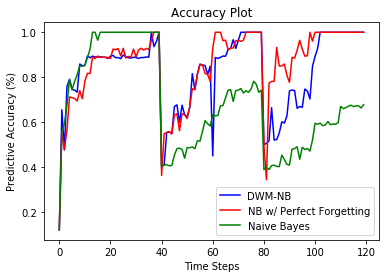

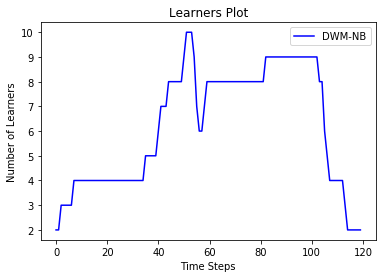

In [0]:
staggerevaluation(120, 5000, 1)

Evaluation with the following parameters:

* Number of time steps = 120
* Number of examples = 5000
* Number of loops = 10

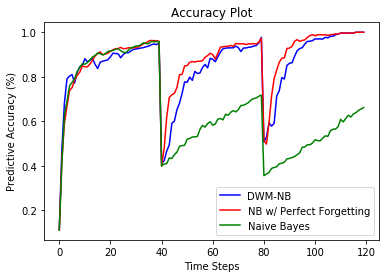

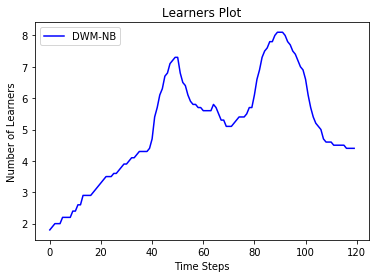

In [0]:
staggerevaluation(120, 5000, 10)

### SEA Implementation

Create SEA dataset function

In [0]:
def sea(time_steps, examples, t):
  features = np.zeros((examples,3))
  labels = np.zeros((examples))

  for i in range(1):
    features[i, 0:3] = [10*np.random.random((1,1)), 10*np.random.random((1,1)), 10*np.random.random((1,1))]

    if (t < int(time_steps/4)):
      if (features[i, 0] + features[i, 1] <= 7):
        labels[i] = 0
      else:
        labels[i] = 1
    elif (t > int(time_steps/4) and (t < int(time_steps/2))):
      if (features[i, 0] + features[i, 1] <= 8):
        labels[i] = 0
      else:
        labels[i] = 1
    elif (t < int(3*time_steps/4) and (t > int(time_steps/2))):
      if (features[i, 0] + features[i, 1] <= 9):
        labels[i] = 0
      else:
        labels[i] = 1
    elif (t > int(3*time_steps/4)):
      if (features[i, 0] + features[i, 1] <= 9.5):
        labels[i] = 0
      else:
        labels[i] = 1

  return features, labels

Create test instances function

In [0]:
def test(steps, t, samples):
  X_test = 10*np.random.random((samples, 3))
  Y_test = np.zeros((samples,1))

  a = int(steps/4)
  b = int(steps/2)
  c = int(3*steps/4)

  if (t < a):
    for i in range(samples):
      if (X_test[i, 0] + X_test[i, 1] <= 7):
        Y_test[i] = 0
      else:
        Y_test[i] = 1
  
  elif (t >= a and t < b):
    for i in range(samples):
      if (X_test[i, 0] + X_test[i, 1] <= 8):
        Y_test[i] = 0
      else:
        Y_test[i] = 1
  
  elif (t < c and t >= b):
    for i in range(samples):
      if (X_test[i, 0] + X_test[i, 1] <= 9):
        Y_test[i] = 0
      else:
        Y_test[i] = 1 
  
  elif (t >= c):
    for i in range(samples):
      if (X_test[i, 0] + X_test[i, 1] <= 9.5):
        Y_test[i] = 0
      else:
        Y_test[i] = 1 
  
  return X_test, Y_test

Evaluate SEA function

In [0]:
def evaluatesea(steps, n, loops, learners_top = False, max_learners = 5):
  beta = 0.5
  th = 0.001
  p = 5
  test_samples = 2500

  learners_hist = np.zeros((steps,loops))
  accuracy_hist = np.zeros((steps,loops))
  perf_accuracy_hist = np.zeros((steps,loops))
  NB_accuracy_hist = np.zeros((steps,loops))

  for l in range(loops):
    e = [GaussianNB()]
    w = [1] 
    m = 1
    perf = GaussianNB()
    NB = GaussianNB()

    perf.partial_fit(10*np.random.random((1,3)), np.array([0]), [0, 1])
    NB.partial_fit(10*np.random.random((1,3)), np.array([0]), [0, 1])
    e[0].partial_fit(10*np.random.random((1,3)), np.array([0]), [0, 1])
    
    for t in range(steps):
      X_train, Y_train = sea(steps, n, t)
      X_test, Y_test = test(steps, t, test_samples)
      sigma = np.zeros((2,1))

      for j, model in enumerate(e):
        local_pred = model.predict(X_train)

        if (local_pred != Y_train):
          w[j] = beta * w[j]
        sigma[local_pred] = sigma[local_pred] + w[j]
      
      glob_pred = np.argmax(sigma)
      pred = np.zeros((X_test.shape[0], 2))

      for j, model in enumerate(e):
        Y_pred = model.predict(X_test)
        for k in range(X_test.shape[0]):
          pred[k, Y_pred[k]] = pred[k, Y_pred[k]] + w[j]
      
      global_prediction = np.argmax(pred, axis=1)
      accuracy_hist[t,l] = accuracy_score(Y_test, global_prediction)

      norm_pred = NB.predict(X_test)
      NB_accuracy_hist[t,l] = accuracy_score(Y_test, norm_pred)

      perf_pred = perf.predict(X_test)
      perf_accuracy_hist[t,l] = accuracy_score(Y_test, perf_pred)

      if(t==int(steps/4) or t==int(steps/2) or t==int(3*steps/4)):
        perf = GaussianNB()

      if (t % p == 0):
        # print(t)
        # print(w)
        w[:] = w[:]/np.max(w)
        # print(w)
        e, w, m = removeExperts(e, w, m, th)

        if (glob_pred != Y_train):
          if (learners_top == False or (learners_top == True and m < max_learners)):
            m += 1
            e.append(GaussianNB())
            w.append(1)
      
      learners_hist[t,l] = m

      for j, model in enumerate(e):
        model.partial_fit(X_train, Y_train, [0, 1])

      perf.partial_fit(X_train, Y_train, [0, 1])
      NB.partial_fit(X_train, Y_train, [0, 1])

  plt.plot(range(steps), np.mean(accuracy_hist, axis=1), label='DWM-NB', color='blue')
  plt.plot(range(steps), np.mean(perf_accuracy_hist, axis=1), label='NB w/ Perfect Forgetting', color='red')
  plt.plot(range(steps), np.mean(NB_accuracy_hist, axis=1), label='Naive Bayes', color='green')
  plt.legend()
  plt.title('Accuracy Plot')
  plt.xlabel('Time Steps')
  plt.ylabel('Predictive Accuracy (%)')
  plt.ylim(0.7,1)
  plt.show()

  plt.plot(range(steps), np.mean(learners_hist, axis=1), label='DWM-NB', color='blue')
  plt.legend()
  plt.title('Learners Plot')
  plt.xlabel('Time Steps')
  plt.ylabel('Number of Learners')
  plt.show()

Evaluation with the following parameters:

* Number of samples = 5000
* Number of loops = 1

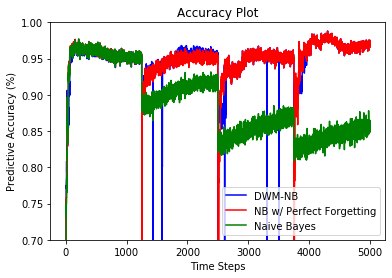

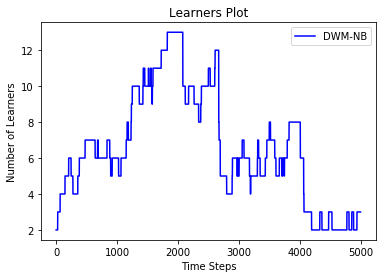

In [0]:
evaluatesea(5000,1,1)

Evaluation with the following parameters:

* Number of samples = 5000
* Number of loops = 5

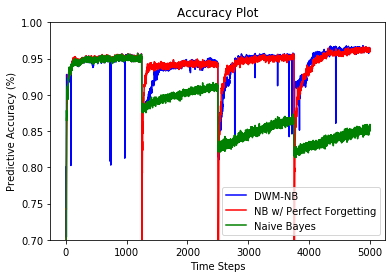

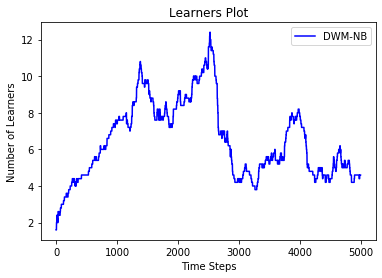

In [0]:
evaluatesea(5000,1,5)

Evaluation with the following parameters:

* Number of samples = 5000
* Number of loops = 5
* Max Learners = 5

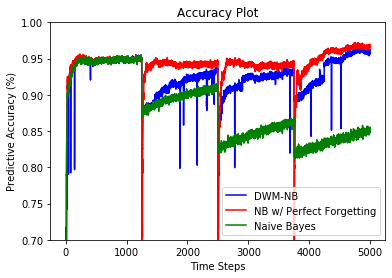

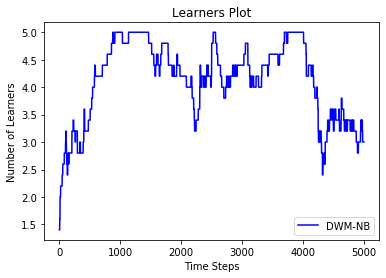

In [0]:
evaluatesea(5000,1,5,True)

Evaluation with the following parameters:

* Number of samples = 5000
* Number of loops = 5
* Max Learners = 10

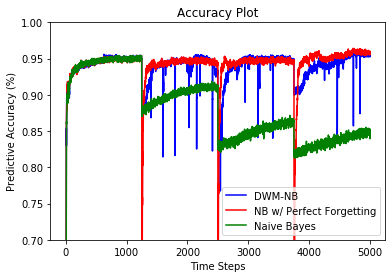

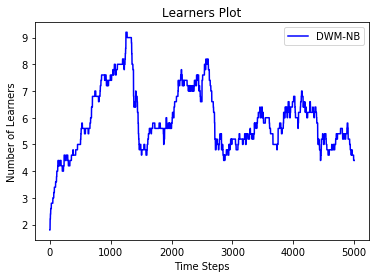

In [0]:
evaluatesea(5000,1,5,True,10)

Evaluation with the following parameters:

* Number of samples = 50000
* Number of loops = 10

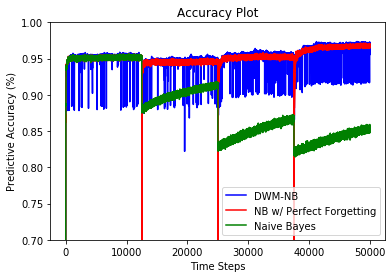

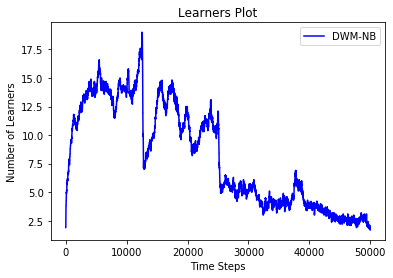

In [0]:
evaluatesea(50000,1,10)

###Intrusion detection dataset

Load and preprocess the dataset

In [0]:
def intrusion_detection():
  num_lines = sum(1 for line in open('kddcup.data_10_percent'))
  data = []
  with open('kddcup.data_10_percent') as my_file:
    for i in range(int(num_lines/1000)):
      data.append(my_file.readline().rstrip())

  df = pd.DataFrame(data[0].split(",")).transpose()
  # df = df.drop([6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 33, 34, 37, 38, 39, 40], axis = 1)

  for i in range(1, int(num_lines/1000)):
    df_aux = pd.DataFrame(data[i].split(",")).transpose()
    # df_aux = df_aux.drop([6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 33, 34, 37, 38, 39, 40], axis = 1)
    df = df.append(df_aux)

  dataset = np.zeros((df.shape))
  label_encoder = preprocessing.LabelEncoder()
  for i in range(df.shape[1]):
    dataset[:, i] = label_encoder.fit_transform(df[[i]])

  features = dataset[:, :dataset.shape[1]-1]
  labels = dataset[:, dataset.shape[1]-1]
  return features, labels

Define the evaluation function

In [0]:
def eval_ID(steps, loops):

  beta = 0.5
  th = 0.01
  p = 1
  learners_hist = np.zeros((steps,loops))
  accuracy_hist = np.zeros((steps,loops))
  NB_accuracy_hist = np.zeros((steps,loops))
  
  for l in range(loops):
    e = [MultinomialNB()]
    w = [1] 
    m = 1
    NB = MultinomialNB()

    NB.partial_fit(np.random.choice(2, (1,41)), np.array([0]), [0, 1])
    e[0].partial_fit(np.random.choice(2, (1,41)), np.array([0]), [0, 1])
    
    for t in range(steps):
      X, Y = intrusion_detection()
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 493/494, random_state=42)
      sigma = np.zeros((2,1))

      for j, model in enumerate(e):
        local_pred = model.predict(X_train)

        if (local_pred != Y_train):
          w[j] = beta * w[j]
        sigma[local_pred] = sigma[local_pred] + w[j]
      
      glob_pred = np.argmax(sigma)
      pred = np.zeros((X_test.shape[0], 2))

      for j, model in enumerate(e):
        Y_pred = model.predict(X_test)
        for k in range(X_test.shape[0]):
          pred[k, Y_pred[k]] = pred[k, Y_pred[k]] + w[j]
      
      global_prediction = np.argmax(pred, axis=1)
      accuracy_hist[t,l] = accuracy_score(Y_test, global_prediction)

      norm_pred = NB.predict(X_test)
      NB_accuracy_hist[t,l] = accuracy_score(Y_test, norm_pred)

      if (t % p == 0):
        w[:] = w[:]/np.max(w)
        e, w, m = removeExperts(e, w, m, th)

        if (glob_pred != Y_train):
          m += 1
          e.append(MultinomialNB())
          w.append(1)
      
      learners_hist[t,l] = m

      for j, model in enumerate(e):
        model.partial_fit(X_train, Y_train, [0, 1])

      NB.partial_fit(X_train, Y_train, [0, 1])

  plt.plot(range(steps), np.mean(accuracy_hist, axis=1), label='DWM-NB', color='blue')
  plt.plot(range(steps), np.mean(NB_accuracy_hist, axis=1), label='Naive Bayes', color='green')
  plt.legend()
  plt.title('Accuracy Plot')
  plt.xlabel('Time Steps')
  plt.ylabel('Predictive Accuracy (%)')
  plt.show()

  plt.plot(range(steps), np.mean(learners_hist, axis=1), label='DWM-NB', color='blue')
  plt.legend()
  plt.title('Learners Plot')
  plt.xlabel('Time Steps')
  plt.ylabel('Number of Learners')
  plt.show()

Evaluation with the following parameters:

* Number of time steps = 100
* Number of loops = 1


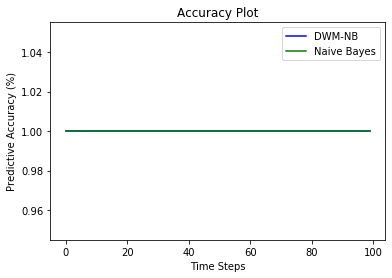

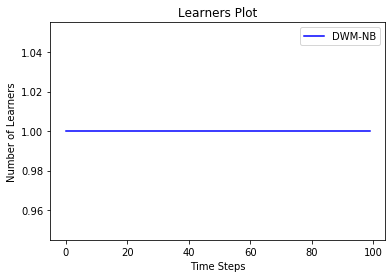

In [29]:
eval_ID(100,1)

The results for this real world dataset are not the expected ones. Therefore, they will not be added to the slides report.